In [44]:
import pandas as pd
import numpy as np
import csv
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [93]:
pid = 'P04'

In [94]:
p_info = pd.read_csv('participants_data.csv')
condition = p_info[p_info.pid == pid].condition.item()
condition_data = pd.read_csv('result/' + pid + '_' + condition + '_training.csv', index_col=0)

In [95]:
ERD_list = []
ERD_per_list = []
for day, block in itertools.product(['Day1', 'Day2'], range(5)):
    if condition == 'continuous':
        file_index = 'FB'
    else:
        file_index = condition
    with open('result/' + pid + '_' + file_index + '_ERSP_' + day + '_b' + str(block) + '.csv', 'r') as f:
            data = list(csv.reader(f, quoting=csv.QUOTE_NONNUMERIC))
        
    for FB in data:
        ERD_list.append(np.average(FB))
        ERD_per_list.append(sum(i < -10 for i in FB) / len(FB))
condition_data['ERSP'] = ERD_list
condition_data['Percent'] = ERD_per_list

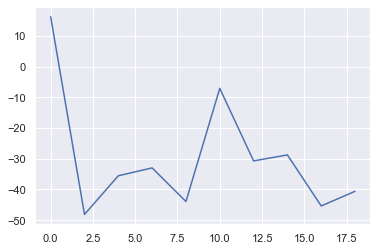

In [96]:
ERSP = condition_data.groupby(['pid', 'condition', 'day', 'block', 'hand'], sort=False, as_index=False).mean()
plt.plot(ERSP[ERSP.hand == 'left']['ERSP'])

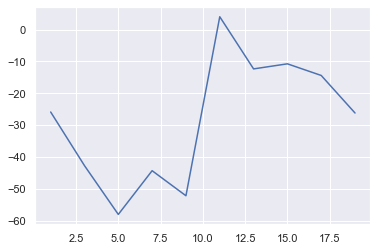

In [97]:
plt.plot(ERSP[ERSP.hand == 'right']['ERSP'])

In [98]:
fatigue = pd.read_csv('result/' + pid + '_fatigue.csv', index_col=0)

In [99]:
fatigue['Percent'] = condition_data.groupby(['pid', 'condition', 'day', 'block'], sort=False, as_index=False).mean().Percent
fatigue['ERSP'] = condition_data.groupby(['pid', 'condition', 'day', 'block'], sort=False, as_index=False).mean().ERSP

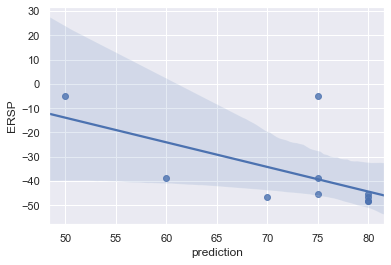

In [100]:
sns.regplot(x='prediction', y='ERSP', data=fatigue)

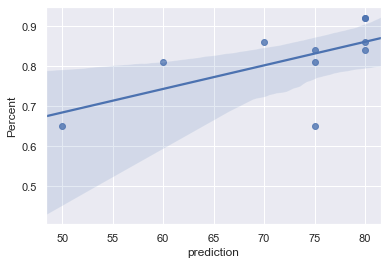

In [101]:
sns.regplot(x='prediction', y='Percent', data=fatigue)